# 2 - Modelling and Evaluation
In this notebook, we will do the following:
    1. Determine the best pre-trained model (on COCO dataset) for our use-case.
    2. Conduct a few-shot eager learning.
    3. Save the model to be used in the real-time application.

>**Project Title** <br>Face Mask Detector</br>
**Course** <br>AIDI-2000-02 Applied Machine Learning</br>
**NOTE** <br>Most of the code in this notebook was inspired by **[akashkam559](https://github.com/akashkam559/)**'s **[GitHub repository](https://github.com/akashkam559/Covid19-Face-Mask-Detector)**. 

# Table of Contents
1. Load modules and dataset
2. Data Preparation and Exploration
3. Model Loading and Training
4. Model Evaluation

# 1. Load Modules and Dataset

## 1.1 Load Modules

In [12]:
# import modules
import pandas as pd
import tensorflow as tf
import pathlib

# Source: YouTube (Nicholas Rente)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

## 1.2 Define Variables

In [77]:
# Define important file paths

# Define model related paths & filenames
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'centernet_mobilenetv2fpn_512x512_coco17_od'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'


# Defining unique locations
WORKSPACE_PATH = '../Tensorflow/workspace'
SCRIPTS_PATH = '../Tensorflow/scripts'
APIMODEL_PATH = '../Tensorflow/models'

# Define dependent locations
ANNOTATION_PATH = os.path.join(WORKSPACE_PATH, 'annotations')
IMAGE_PATH = os.path.join(WORKSPACE_PATH, 'images')
MODEL_PATH = os.path.join(WORKSPACE_PATH, 'models')
PRETRAINED_MODEL_PATH = os.path.join(WORKSPACE_PATH, 'pre-trained-models')
CONFIG_PATH = os.path.join(MODEL_PATH, 'my_ssd_mobnetV2_512x512/pipeline.config')
CHECKPOINT_PATH = os.path.join(MODEL_PATH, 'my_ssd_mobnetV2_512x512/')

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BATCH = 32

## 1.3 Load dataset

In [78]:
# Get list of images in the dataset directory
imagePaths = list(paths.list_images(DATASETDIR_PATH))

# Initialize imp lists
data = []
labels = []

# 2. Data Preparation and Exploration

## 2.1 Data Cleansing & Transformation

In [79]:
for imagePath in imagePaths:
    # Class label from directory name
    label = imagePath.split(os.path.sep)[-2]

    # Load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # Update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

In [80]:
# Convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [81]:
# Split the dataset | 80 train - 20 test split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size = 0.20,
                                                  stratify = labels,
                                                  random_state = 42)

## 2.2 Exploratory Data Analsyis

In [82]:
trainX.shape

(96, 224, 224, 3)

In [83]:
trainY.shape

(96, 2)

In [84]:
f"Percentage of images with mask (of the total images): {sum(trainY[:, 0]) / len(trainY): .0%}"

'Percentage of images with mask (of the total images):  67%'

In [107]:
import pandas as pd

data = pd.DataFrame({
    "train": {
        "mask": sum(trainY[:, 0]),
        "no mask": sum(trainY[:, 1])
    },
    "test": {
        "mask": sum(testY[:, 0]),
        "no mask": sum(testY[:, 1])
    }
})

data

,train,test
mask,64.0,16.0
no mask,32.0,8.0


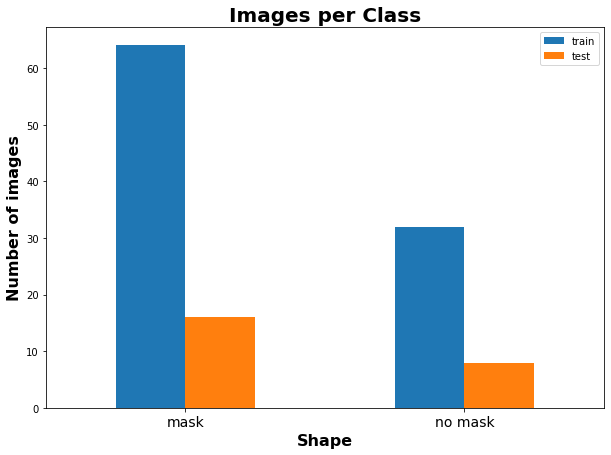

In [108]:
# Instantiate plot
fig, ax = plt.subplots(figsize=(7,7))

# Bar plot for training and testing data)
data.plot(kind='bar', figsize=(10,7), ax=ax)

# Formatting
plt.xlabel('Shape', fontdict={'size': 16, 'weight': 'bold'});
plt.ylabel('Number of images', fontdict={'size': 16, 'weight': 'bold'});
plt.title('Images per Class', fontdict={'size': 20, 'weight': 'bold'});
plt.xticks(rotation=0, fontsize=14);

# 3. Model Loading and Training

## 3.1 Pre-train Model Selection

> Goal: To build a **real-time** face mask detector ensure the right balance between speed and accuracy (mAP).

In this section, we will use the [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) table and metrics to determine the ideal model with the highest accuracy and fastest speed (lowest value).

In [109]:
# Load data about pretrained model
df = pd.read_csv('../Tensorflow/workspace/data/TF2-detection-model-zoo-meta.csv')
df.head()

,Model name,Speed (ms),COCO mAP,Outputs
0,CenterNet HourGlass104 512x512,70,41.9,Boxes
1,CenterNet HourGlass104 Keypoints 512x512,76,50.7,Boxes/Keypoints
2,CenterNet HourGlass104 1024x1024,197,44.5,Boxes
3,CenterNet HourGlass104 Keypoints 1024x1024,211,53.6,Boxes/Keypoints
4,CenterNet Resnet50 V1 FPN 512x512,27,31.2,Boxes


We want the model with the highest accuracy and lowest inference time (fastest speed). Therefore, we can create a new variables that takes the ratio of the two metrics - `COCO mAP / Speed (ms)`. Maximizing this ratio will give us the models that will work best for the use-case. 

> Note: Many assumptions are in the above model selection process. One of them being the model size - this is usaully given in terms of `training parameters`. As these models are already trained, the size of the models is not taken into consideration. However, many other factors that could impact the decision of selecting the perfect model are assumed to have negligible impact. 

In [110]:
# Create column for ratio
df['mAP/Speed Ratio'] = df['COCO mAP'] / df['Speed (ms)']
df.sort_values(by='mAP/Speed Ratio', ascending=False).head(10)

,Model name,Speed (ms),COCO mAP,Outputs,mAP/Speed Ratio
10,CenterNet MobileNetV2 FPN Keypoints 512x512,6,41.7,Keypoints,6.950000
9,CenterNet MobileNetV2 FPN 512x512,6,23.4,Boxes,3.900000
5,CenterNet Resnet50 V1 FPN Keypoints 512x512,30,40.0,Boxes/Keypoints,1.333333
8,CenterNet Resnet50 V2 Keypoints 512x512,30,37.9,Boxes/Keypoints,1.263333
4,CenterNet Resnet50 V1 FPN 512x512,27,31.2,Boxes,1.155556
7,CenterNet Resnet50 V2 512x512,27,29.5,Boxes,1.092593
19,SSD MobileNet v2 320x320,19,20.2,Boxes,1.063158
21,SSD MobileNet V2 FPNLite 320x320,22,22.2,Boxes,1.009091
6,CenterNet Resnet101 V1 FPN 512x512,34,34.2,Boxes,1.005882
11,EfficientDet D0 512x512,39,33.6,Boxes,0.861538


Consideirng the ratio and limits of accuracy and speed, the best pre-trained model to be used for the use-case is **`CenterNet MobileNet V2 FPN 512x512`**

## 3.2 Pre-train model load & setup

In [111]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

## 3.3 Model Training

In [132]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH),
    steps_per_epoch=len(trainX) // BATCH,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20


2022-04-22 12:11:17.614529: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-22 12:11:18.693333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 279ms/step - loss: 0.8399 - accuracy: 0.4688
Epoch 2/20
3/3 [==============================] - 1s 146ms/step - loss: 0.7569 - accuracy: 0.5208
Epoch 3/20
3/3 [==============================] - 1s 150ms/step - loss: 0.7020 - accuracy: 0.6354
Epoch 4/20
3/3 [==============================] - 1s 184ms/step - loss: 0.6471 - accuracy: 0.6667
Epoch 5/20
3/3 [==============================] - 1s 153ms/step - loss: 0.5768 - accuracy: 0.6875
Epoch 6/20
3/3 [==============================] - 1s 144ms/step - loss: 0.5778 - accuracy: 0.7188
Epoch 7/20
3/3 [==============================] - 1s 154ms/step - loss: 0.5046 - accuracy: 0.7604
Epoch 8/20
3/3 [==============================] - 1s 157ms/step - loss: 0.5014 - accuracy: 0.7604
Epoch 9/20
3/3 [==============================] - 1s 143ms/step - loss: 0.4246 - accuracy: 0.8542
Epoch 10/20
3/3 [==============================] - 1s 141ms/step - loss: 0.4585 - accuracy: 0.8438
Epoch 11/20
3/3 [=============

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BATCH)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model_name = "mask_detector_20.model"
model.save(os.path.join(MODEL_PATH, model_name), save_format="h5")

# 4.0 Model Evaluation

[INFO] evaluating network...
              precision    recall  f1-score   support

        mask       1.00      1.00      1.00        16
     no mask       1.00      1.00      1.00         8

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

[INFO] saving mask detector model...


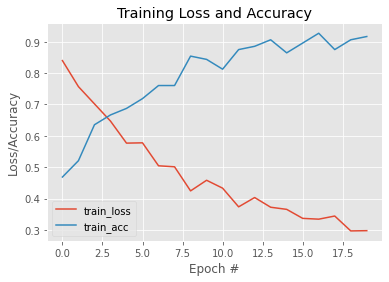

In [139]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left");